## CS310 Natural Language Processing
## Assignment 2. Word2vec Implementation 

**Total points**: 50

Train a word2vec model using the **skip-gram** architecture and **negative sampling**.

You should roughtly follow the structure of the notebook. Add additional cells if you feel needed. 

You can (and you should) re-use the code from *Lab 4 (part 2): Data preparation for implementing word2vec*. 

Make sure your code is readable and well-structured.

### 0. Import Necessary Libraries

In [ ]:
import time
import torch
import gensim
import numpy as np
import torch.nn as nn
from typing import List
from utils import CorpusReader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.decomposition import TruncatedSVD
from torch.nn.utils import clip_grad_norm_


## 1. Data Processing

The corpus data is in `lunyu_20chapters.txt`. Use the `CorpusReader` class in `utils.py` to help you.

In [38]:
# Read raw data in lunyu_20chapters.txt
corpus = CorpusReader(inputFileName="lunyu_20chapters.txt", min_count=1)
with open('lunyu_20chapters.txt', 'r', encoding='utf-8') as file:
    data = file.read()
data=data.replace('\n','')

Total vocabulary: 1352


In [39]:
# Re-use the code from lab with necessary modifications

def generate_data(words: List[str], window_size: int, k: int, corpus: CorpusReader):
    """ Generate the training data for word2vec skip-gram model
    Args:
        text: the input text
        window_size: the size of the context window
        k: the number of negative samples
        corpus: the corpus object, providing utilities such as word2id, getNegatives, etc.
    """
    word_ids = [corpus.word2id[word] for word in words]
    
    for i, center_word_id in enumerate(word_ids):
        # Avoid out-of-range indices
        start = max(0, i - window_size)
        end = min(len(word_ids), i + window_size + 1)
        
        for j in range(start, end):
            # Skip the center word itself
            if i != j:
                context_word_id = word_ids[j]
                negative_samples = corpus.getNegatives(center_word_id, k)
                yield center_word_id, context_word_id, negative_samples

def batchify(data: List, batch_size: int):
    """ Group a stream into batches and yield them as torch tensors.
    Args:
        data: a list of tuples
        batch_size: the batch size 
    Yields:
        a tuple of three torch tensors: center, outside, negative
    """
    assert batch_size < len(data) # data should be long enough
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        if i > len(data) - batch_size: # if the last batch is smaller than batch_size, pad it with the first few data
            batch = batch + data[:i + batch_size - len(data)]
        
        center = torch.LongTensor(np.array([item[0] for item in batch]))
        outside = torch.LongTensor(np.array([item[1] for item in batch]))
        negative = torch.LongTensor(np.array([item[2] for item in batch]))
        yield center, outside, negative

## 2. Define the Model

In [40]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.emb_v = nn.Embedding(vocab_size, emb_size, sparse=True)
        self.emb_u = nn.Embedding(vocab_size, emb_size, sparse=True)

        initrange = 1.0 / self.emb_size # some experience passed down from generation to generation
        nn.init.uniform_(self.emb_v.weight.data, -initrange, initrange) # same outcome as self.emb_v.weight.data.uniform_(-initrange, initrange)
        nn.init.constant_(self.emb_u.weight.data, 0) # same outcome as self.emb_u.weight.data.zero_()

    def forward(self, center, outside, negative):
        """
        Args:
            center: the center word indices (B, )
            outside: the outside word indices (B, )
            negative: the negative word indices (B, k)
        """
        v_c = self.emb_v(center)
        u_o = self.emb_u(outside)
        u_n = self.emb_u(negative)
        
        pos_score = torch.sum(torch.mul(v_c, u_o), dim=1)
        pos_score = torch.clamp(pos_score, max=10, min=-10)
        pos_score = F.logsigmoid(pos_score)

        neg_score = torch.bmm(u_n, -v_c.unsqueeze(2)).squeeze(2)
        neg_score = torch.clamp(neg_score, max=10, min=-10)
        neg_score = F.logsigmoid(neg_score)  
        neg_score = torch.sum(neg_score, dim=1)

        loss = -pos_score - neg_score

        return loss
        # Hint: torch.clamp the input to F.logsigmoid to avoid numerical underflow/overflow
    
    def save_embedding(self, id2word, file_name):
        embedding = self.emb_v.weight.cpu().data.numpy()
        with open(file_name, 'w') as f:
            f.write('%d %d\n' % (len(id2word), self.emb_size))
            for wid, w in id2word.items():
                e = ' '.join(map(lambda x: str(x), embedding[wid]))
                f.write('%s %s\n' % (w, e))

## 3.1 Train and Evaluate

In [41]:
def train(model, dataloader, optimizer, scheduler, epochs):
    """
    Train the Skip-Gram model with negative sampling.

    Args:
        model: The Skip-Gram model to train.
        dataloader: DataLoader providing batches of (center_word, context_word, negative_words).
        optimizer: Optimizer for updating model parameters.
        scheduler: Learning rate scheduler.
        epochs: Number of training epochs.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Determine the device (GPU or CPU)
    model.to(device)  
    model.train()

    print_interval = 1000 

    for epoch in range(epochs):
        total_loss = 0.0
        iterations = 0

        for i, (center_word, context_word, negative_words) in enumerate(dataloader):
            center_word = center_word.to(device)
            context_word = context_word.to(device)
            negative_words = negative_words.to(device)

            optimizer.zero_grad()
            loss = model(center_word, context_word, negative_words).mean() 
            loss.backward() 
            # clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            total_loss += loss.item()
            iterations += 1

            if (i + 1) % print_interval == 0:
                avg_loss = total_loss / iterations
                print(f'Epoch: {epoch + 1}, Iteration: {i + 1}, Loss: {avg_loss}')

        scheduler.step() 
        avg_epoch_loss = total_loss / iterations
        print(f'Epoch: {epoch + 1}, Average Loss: {avg_epoch_loss:.4f}')

# Suggested hyperparameters
initial_lr = 0.025
batch_size = 16
emb_size = 50 # 50, 100
window_size = 1 # 1, 3
k = 2 # 2, 5
min_count = 1
epochs = 10

# Initialize the corpus and model
corpus = CorpusReader('lunyu_20chapters.txt', min_count)
vocab_size = corpus.vocab_size
model = SkipGram(vocab_size, emb_size)
optimizer = torch.optim.SparseAdam(model.parameters(), lr=initial_lr) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# Test train
generated_data= list(generate_data(list(data), window_size, k, corpus))
dataloader = list(batchify(generated_data, batch_size))
# train(model, dataloader, optimizer, scheduler, epochs)

Total vocabulary: 1352


## 4 Training with Different Hyperparameters and Save Embeddings


In [43]:
# Define hyperparameter combinations
emb_sizes = [50, 100]
k_values = [2, 5]
window_sizes = [1, 3]

# Fixed hyperparameters
initial_lr = 0.025
batch_size = 16
min_count = 1
epochs = 10

corpus = CorpusReader(inputFileName="lunyu_20chapters.txt", min_count=min_count)
vocab_size = corpus.vocab_size

# Function to save embeddings
def save_embeddings(model, vocab_size, emb_size, output_file):
    weights = model.emb_v.weight.detach().cpu().numpy()
    with open(output_file, "w", encoding="utf-8") as f:
        f.write(f"{vocab_size} {emb_size}\n")
        for idx, vector in enumerate(weights):
            vector_str = " ".join(map(str, vector))
            f.write(f"{corpus.id2word[idx]} {vector_str}\n")

for emb_size in emb_sizes:
    for k in k_values:
        for window_size in window_sizes:
            print(f"Training with emb_size={emb_size}, k={k}, window_size={window_size}")

            model = SkipGram(vocab_size, emb_size)
            optimizer = torch.optim.SparseAdam(model.parameters(), lr=initial_lr) 
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

            generated_data= list(generate_data(list(data), window_size, k, corpus))
            dataloader = list(batchify(generated_data, batch_size))

            start_time = time.time()
            train(model, dataloader, optimizer, scheduler, epochs)
            training_time = time.time() - start_time

            output_file = f"embeddings_emb{emb_size}_k{k}_win{window_size}.txt"
            save_embeddings(model, vocab_size, emb_size, output_file)

            print(f"Training completed in {training_time:.2f} seconds")
            print(f"Embeddings saved to {output_file}\n")

Total vocabulary: 1352
Training with emb_size=50, k=2, window_size=1
Epoch: 1, Iteration: 1000, Loss: 2.0015089514255524
Epoch: 1, Iteration: 2000, Loss: 1.9993712645173072
Epoch: 1, Average Loss: 2.0228
Epoch: 2, Iteration: 1000, Loss: 1.7760950303673744
Epoch: 2, Iteration: 2000, Loss: 1.6500907532572746
Epoch: 2, Average Loss: 1.6224
Epoch: 3, Iteration: 1000, Loss: 1.3584402789771557
Epoch: 3, Iteration: 2000, Loss: 1.298840090587735
Epoch: 3, Average Loss: 1.2871
Epoch: 4, Iteration: 1000, Loss: 1.167239098340273
Epoch: 4, Iteration: 2000, Loss: 1.1298438046574593
Epoch: 4, Average Loss: 1.1245
Epoch: 5, Iteration: 1000, Loss: 1.0762982543110848
Epoch: 5, Iteration: 2000, Loss: 1.0459974216669798
Epoch: 5, Average Loss: 1.0426
Epoch: 6, Iteration: 1000, Loss: 1.0205550280213356
Epoch: 6, Iteration: 2000, Loss: 0.9932149418666959
Epoch: 6, Average Loss: 0.9901
Epoch: 7, Iteration: 1000, Loss: 0.9842702920436859
Epoch: 7, Iteration: 2000, Loss: 0.9566413144767284
Epoch: 7, Average L

## 5. Plot and Compare Embeddings

Use `sklearn.decomposition.TruncatedSVD` to reduce the dimensionality of the obtained embeddings to 2 and plot the selected words in 2D space.

*Hint*:
- Obtain the embeddings into a numpy array by `model.emb_v.cpu().data.numpy()`
- The word2id dictionary is in `model.word2id`
- If you are trying to load from a saved embedding file, you can use the APIs from `gensim`.
  - For exmaple, `model = gensim.models.KeyedVectors.load_word2vec_format('path/to/file')`
  - Check out the documentation for more details: https://radimrehurek.com/gensim/models/keyedvectors.html

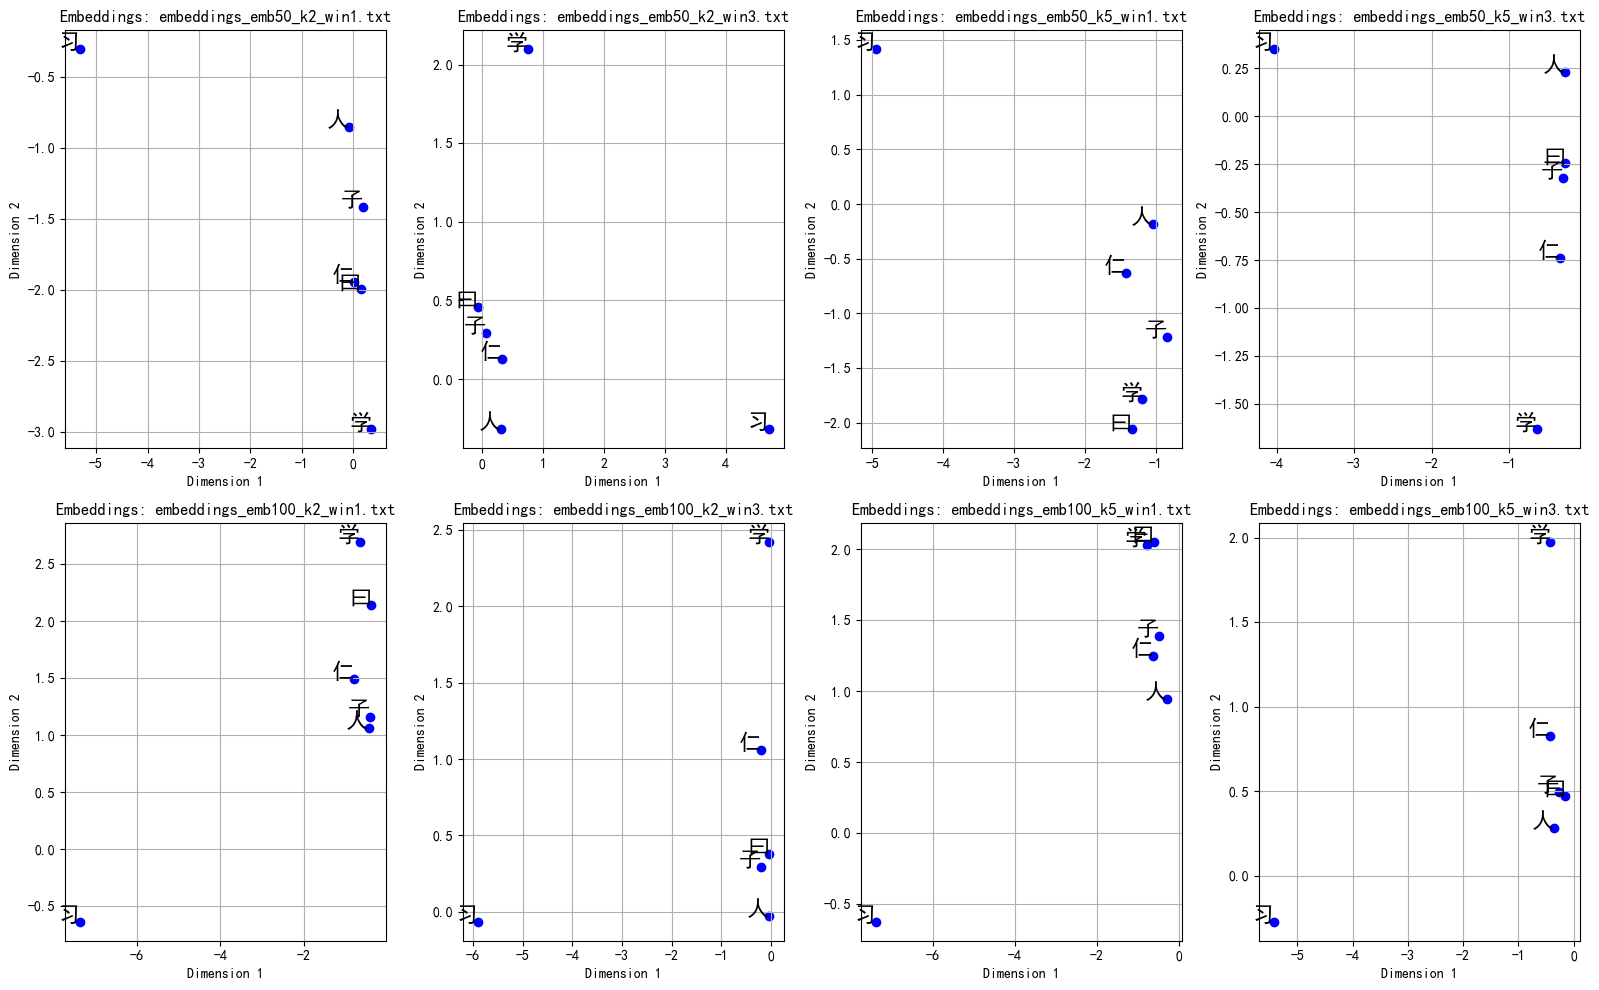

In [52]:
# Plot the following words or other words you are interested in
# You better pick those words that look different in the 2D space compared with the LSA vectors
words = ['学', '习', '曰', '子', '人', '仁']
words_pinyin = ['xue', 'xi', 'yue', 'zi', 'ren1', 'ren2']
embedding_files = [
    "embeddings_emb50_k2_win1.txt",
    "embeddings_emb50_k2_win3.txt",
    "embeddings_emb50_k5_win1.txt",
    "embeddings_emb50_k5_win3.txt",
    "embeddings_emb100_k2_win1.txt",
    "embeddings_emb100_k2_win3.txt",
    "embeddings_emb100_k5_win1.txt",
    "embeddings_emb100_k5_win3.txt"
]
# Set a CJK-compatible font
plt.rcParams['font.sans-serif'] = ['SimHei']  # Use SimHei for Chinese characters
plt.rcParams['axes.unicode_minus'] = False  # Fix negative sign display issues

plt.figure(figsize=(16, 10))

for i, file in enumerate(embedding_files):
    model = gensim.models.KeyedVectors.load_word2vec_format(file, binary=False)
    
    target_embeddings = []
    valid_words = []
    for word in words:
        if word in model:
            target_embeddings.append(model[word])  
            valid_words.append(word)
        else:
            print(f"Word '{word}' not found in {file}")
    
    # Convert embeddings to a NumPy array
    target_embeddings = np.array(target_embeddings) 
    
    # Reduce dimensionality to 2 using TruncatedSVD
    svd = TruncatedSVD(n_components=2)
    embeddings_2d = svd.fit_transform(target_embeddings)  
    
    plt.subplot(2, 4, i + 1)  
    for j, word in enumerate(valid_words):
        x, y = embeddings_2d[j]
        plt.scatter(x, y, marker='o', color='blue')
        plt.text(x, y, word, fontsize=16, ha='right')
    
    plt.title(f"Embeddings: {file}")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid()

plt.tight_layout()
plt.show()